##### source: https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering

In [ ]:
# import sys
# !{sys.executable} -m pip install numpy pandas matplotlib sklearn seaborn
# !{sys.executable} -m pip install fuzzywuzzy

In [1]:
import pprint
pp = pprint.PrettyPrinter(indent=2)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import time

warnings.filterwarnings('ignore')
%matplotlib inline

##### Loading in data

In [2]:
def load_ratings():
    COL_NAME = ['uid','mid','rating','timestamp']
    df = pd.read_csv('data/movie-ratings.dat',sep='::', header=None, engine='python', names=COL_NAME)
    return df

def load_movies():
    COL_NAME = ['mid','movie_name','movie_genre']
    df = pd.read_csv('data/movie-movies.dat',sep='::', header=None, engine='python', names=COL_NAME)
    return df

def load_users():
    COL_NAME = ['uid','user_fea1','user_fea2','user_fea3','user_fea4']
    df = pd.read_csv('data/movie-users.dat',sep='::', header=None, engine='python', names=COL_NAME)
    return df

In [3]:
users = load_users()
users.head()

,uid,user_fea1,user_fea2,user_fea3,user_fea4
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [4]:
users.shape

(6040, 5)

In [5]:
movies = load_movies()
movies.head()

,mid,movie_name,movie_genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movies.shape

(3883, 3)

In [7]:
ratings = load_ratings()
ratings.head()

,uid,mid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:
ratings.shape

(1000209, 4)

In [9]:
from scipy.sparse import csr_matrix

# pivot ratings into movie features
movie_features = ratings.pivot(index='mid', columns='uid', values='rating').fillna(0)
movie_features.head()

uid,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
mid,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# convert dataframe of movie features to scipy sparse matrix
mat_movie_features = csr_matrix(movie_features.values)

In [11]:
# filter data
movies_cnt = pd.DataFrame(ratings.groupby('mid').size(), columns=['count'])
movies_cnt.head()

,count
mid,
1,2077
2,701
3,478
4,170
5,296


In [12]:
popular_movies = list(set(movies_cnt.query('count >= 1').index))  # noqa
movies_filter = ratings.mid.isin(popular_movies).values

In [13]:
users_cnt = pd.DataFrame(ratings.groupby('uid').size(), columns=['count'])
users_cnt.head()

,count
uid,
1,53
2,129
3,51
4,21
5,198


In [14]:
active_users = list(set(users_cnt.query('count >= 1').index))  # noqa
users_filter = ratings.uid.isin(active_users).values

In [15]:
ratings_filtered = ratings[movies_filter & users_filter]
ratings_filtered.head()

,uid,mid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [16]:
# pivot and create movie-user matrix
movie_user_mat = ratings_filtered.pivot(index='mid', columns='uid', values='rating').fillna(0)
movie_user_mat.head()

uid,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
mid,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# create mapper from movie title to index
hashmap = {  movie: i for i, movie in enumerate(list(movies.set_index('mid').loc[movie_user_mat.index].movie_name)) }
hashmap

{'Toy Story (1995)': 0,
 'Jumanji (1995)': 1,
 'Grumpier Old Men (1995)': 2,
 'Waiting to Exhale (1995)': 3,
 'Father of the Bride Part II (1995)': 4,
 'Heat (1995)': 5,
 'Sabrina (1995)': 6,
 'Tom and Huck (1995)': 7,
 'Sudden Death (1995)': 8,
 'GoldenEye (1995)': 9,
 'American President, The (1995)': 10,
 'Dracula: Dead and Loving It (1995)': 11,
 'Balto (1995)': 12,
 'Nixon (1995)': 13,
 'Cutthroat Island (1995)': 14,
 'Casino (1995)': 15,
 'Sense and Sensibility (1995)': 16,
 'Four Rooms (1995)': 17,
 'Ace Ventura: When Nature Calls (1995)': 18,
 'Money Train (1995)': 19,
 'Get Shorty (1995)': 20,
 'Copycat (1995)': 21,
 'Assassins (1995)': 22,
 'Powder (1995)': 23,
 'Leaving Las Vegas (1995)': 24,
 'Othello (1995)': 25,
 'Now and Then (1995)': 26,
 'Persuasion (1995)': 27,
 'City of Lost Children, The (1995)': 28,
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)': 29,
 'Dangerous Minds (1995)': 30,
 'Twelve Monkeys (1995)': 31,
 'Wings of Courage (1995)': 32,
 'Babe (1995)'

In [18]:
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [19]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [20]:
# utils import
from fuzzywuzzy import fuzz

def fuzzy_matching(hashmap, fav_movie):
    """
        return the closest match via fuzzy ratio.
        If no match found, return None
        Parameters
        ----------
        hashmap: dict, map movie title name to index of the movie in data
        fav_movie: str, name of user input movie
        Return
        ------
        index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in hashmap.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        return -1
    else:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
        return match_tuple[0][1]

In [45]:
# inference
def inference_movie(idx):
    """
        return top n similar movie recommendations based on user's input movie
        ------
        list of top n similar movie recommendations
    """
    n_recommendations = 10
    print('Recommendation system start to make inference')
    print('......\n')
    t0 = time.time()
    distances, indices = model.kneighbors(mat_movie_features[idx], n_neighbors=n_recommendations+1)

    # get list of raw idx of recommendations
    raw_recommends = \
                sorted(
                    list(
                        zip(
                            indices.squeeze().tolist(),
                            distances.squeeze().tolist()
                        )
                    ),
                    key=lambda x: x[1]
                )[:0:-1]
    print('It took my system {:.2f}s to make inference \n'.format(time.time() - t0))

    # print results
    reverse_hashmap = {v: k for k, v in hashmap.items()}
    print("Recommendations for '{}':".format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_hashmap[idx], dist))

fav_movie = 'Wild Bill'
print('You have input movie:', fav_movie)

# get input movie index
idx = fuzzy_matching(hashmap, fav_movie)
if idx > 0:
    inference_movie(idx)
else:
    print('Oops! No match is found')

You have input movie: Wild Bill
Found possible matches in our database: ['Wild Bill (1995)']

Recommendation system start to make inference
......

It took my system 0.11s to make inference 

Recommendations for 'Wild Bill':
1: Wild Bunch, The (1969), with distance of 0.8021413896389098
2: Jeremiah Johnson (1972), with distance of 0.8016973943641691
3: Pale Rider (1985), with distance of 0.8008074931734962
4: High Plains Drifter (1972), with distance of 0.8002094450486011
5: Once Upon a Time in the West (1969), with distance of 0.7955353007622473
6: Quick and the Dead, The (1995), with distance of 0.7906380908649893
7: Tombstone (1993), with distance of 0.7819677898808339
8: Bad Girls (1994), with distance of 0.7651499676403597
9: Geronimo: An American Legend (1993), with distance of 0.7088244931193628
10: Wyatt Earp (1994), with distance of 0.7002855877352234


##### Note:
Item Based Collaborative Filtering:
1. popularity bias: recommender is prone to recommender popular items.
2. item cold-start problem: recommender fails to recommend new or less-known items because items have either none or very little interactions.
3. scalability issue: refers to lack of the ability to scale to much larger sets of data when more and more users and movies added into our database.

#### Exploratory data analysis
##### Plot the counts of each rating

In [28]:
num_users = len(ratings.uid.unique())
num_items = len(ratings.mid.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 6040 unique users and 3706 unique movies in this data set


In [29]:
# get count
ratings_cnt_tmp = pd.DataFrame(ratings.groupby('rating').size(), columns=['count'])
ratings_cnt_tmp

,count
rating,
1,56174
2,107557
3,261197
4,348971
5,226310


In [30]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
ratings_cnt = ratings_cnt_tmp.append( pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),verify_integrity=True,).sort_index()
ratings_cnt

,count
0.0,21384031
1.0,56174
2.0,107557
3.0,261197
4.0,348971
5.0,226310


In [31]:
# add log count
ratings_cnt['log_count'] = np.log(ratings_cnt['count'])
ratings_cnt

,count,log_count
0.0,21384031,16.878155
1.0,56174,10.936209
2.0,107557,11.585776
3.0,261197,12.473030
4.0,348971,12.762744
5.0,226310,12.329661


Text(0,0.5,'number of ratings')

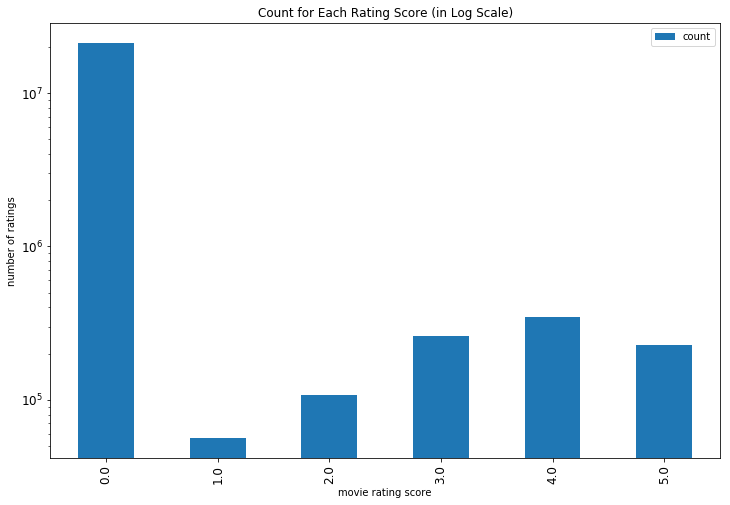

In [32]:
ax = ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x = 'rating score',
    y = 'count',
    kind = 'bar',
    figsize = (12, 8),
    title = 'Count for Each Rating Score (in Log Scale)',
    logy = True,
    fontsize = 12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

##### Plot rating frequency of all movies

In [33]:
ratings.head()

,uid,mid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [34]:
# get rating frequency
movies_cnt = pd.DataFrame(ratings.groupby('mid').size(), columns=['count'])
movies_cnt.head()

,count
mid,
1,2077
2,701
3,478
4,170
5,296


Text(0,0.5,'number of ratings')

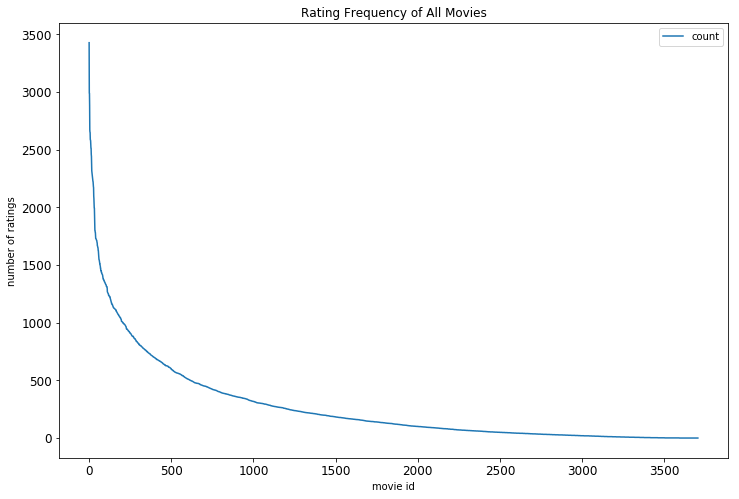

In [35]:
# plot rating frequency of all movies
ax = movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie id")
ax.set_ylabel("number of ratings")

Text(0,0.5,'number of ratings (log scale)')

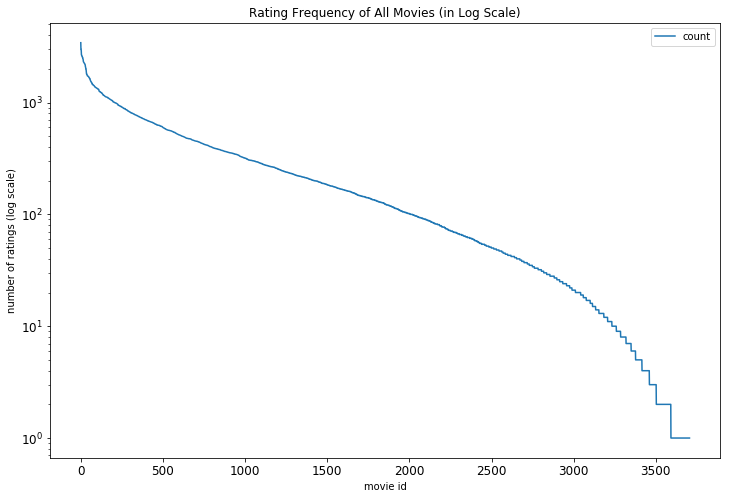

In [36]:
# plot rating frequency of all movies in log scale
ax = movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie id")
ax.set_ylabel("number of ratings (log scale)")

In [37]:
movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    3428.00
0.95    1051.50
0.90     729.50
0.85     553.25
0.80     429.00
0.75     350.00
0.70     280.00
0.65     228.00
Name: count, dtype: float64

In [39]:
# filter data
popularity_thres = 50
popular_movies = list(set(movies_cnt.query('count >= @popularity_thres').index))
ratings_drop_movies = ratings[ratings.mid.isin(popular_movies)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', ratings_drop_movies.shape)

shape of original ratings data:  (1000209, 4)
shape of ratings data after dropping unpopular movies:  (977839, 4)


In [40]:
# get number of ratings given by every user
users_cnt = pd.DataFrame(ratings_drop_movies.groupby('uid').size(), columns=['count'])
users_cnt.head()

,count
uid,
1,53
2,128
3,51
4,21
5,192


Text(0,0.5,'number of ratings')

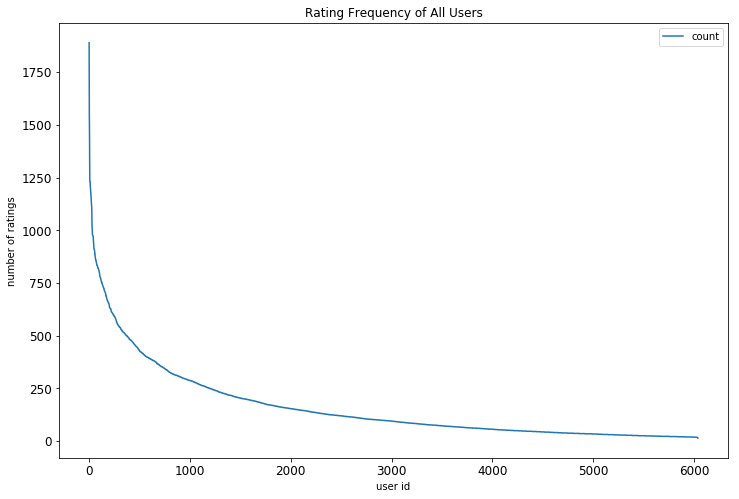

In [41]:
# plot rating frequency of all movies
ax = users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user id")
ax.set_ylabel("number of ratings")

In [42]:
users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    1890.00
0.95     540.05
0.90     391.10
0.85     305.00
0.80     249.00
0.75     203.00
0.70     170.00
0.65     146.00
0.60     124.00
0.55     107.00
Name: count, dtype: float64

In [43]:
# filter data
ratings_thres = 50
active_users = list(set(users_cnt.query('count >= @ratings_thres').index))
ratings_drop_users = ratings_drop_movies[ratings_drop_movies.uid.isin(active_users)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', ratings_drop_users.shape)

shape of original ratings data:  (1000209, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (920334, 4)
